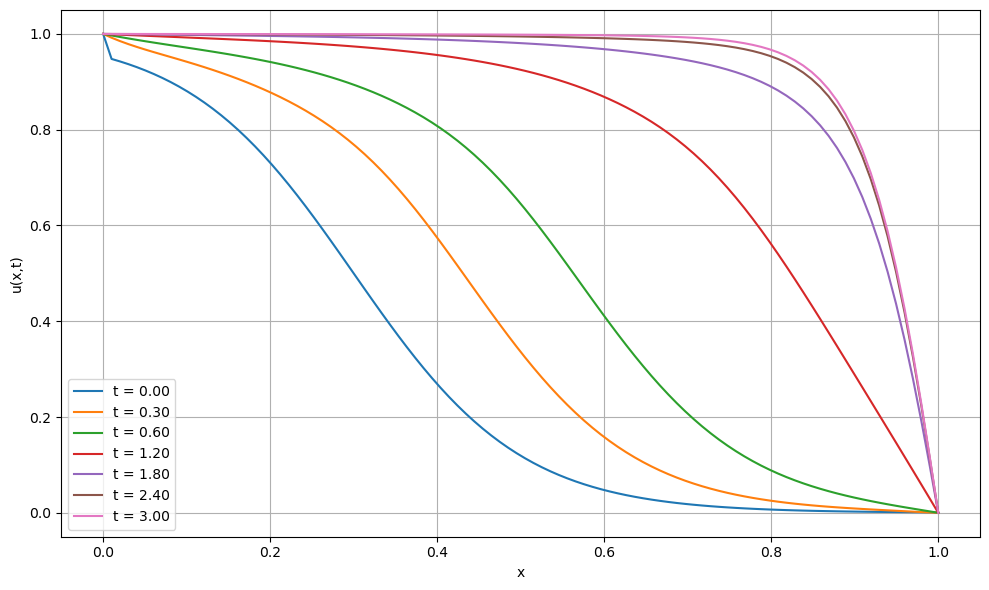

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, identity
from scipy.sparse.linalg import spsolve

# -------------------- Paraméterek --------------------
nu = 0.01
r = 4.0
L = 1.0
T = 3

Nx = 100
Nt = 10
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]
dt = T / Nt

u_left, u_right = 1.0, 0.0

# ------------------- Kezdeti profil ------------------
u = 1 / (1 + np.exp(10 * (x - 0.3)))
u_inner = u[1:-1].copy()

# ---------------- IMEX RK(2,2,2) koefficiensek --------
gamma = (2 - np.sqrt(2)) / 2

A_impl = np.array([
    [0.0,      0.0,   0.0],
    [0.0,  gamma, 0.0],
    [0.0,        1 - gamma, gamma]
])

A_expl = np.array([
    [0.0, 0.0, 0.0],
    [gamma, 0.0, 0.0],
    [1 - 1/(2*gamma), 1/(2*gamma), 0.0]
])

b_impl = np.array([0.0, 1 - gamma, gamma])
b_expl = np.array([1 - 1/(2*gamma), 1/(2*gamma), 0.0])

n_stages = 3

# ---------------- Laplace-operátor ------------------
main_diag = -2.0 * np.ones(Nx - 2)
off_diag  =  1.0 * np.ones(Nx - 3)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]) / dx**2
L_mat = nu * laplacian
I = identity(Nx - 2)

b_vec = np.zeros(Nx - 2)
b_vec[0] = nu / dx**2 * u_left

# ---------------- Reakciótag ------------------------
def f_react(u_vec):
    return r * u_vec * (1.0 - u_vec)

# ---------------- Snapshot tárolás ------------------
snap_indices = {0,
                int(0.05*Nt), int(0.10*Nt), int(0.15*Nt), int(0.20*Nt), int(0.25*Nt),
                int(0.40*Nt), int(0.60*Nt), int(0.80*Nt), Nt}
snapshots = []

def save_snapshot():
    u_full = np.empty_like(u)
    u_full[0], u_full[-1] = u_left, u_right
    u_full[1:-1] = u_inner
    snapshots.append(u_full)

save_snapshot()

# ---------------- Időintegrálás ---------------------
u_stage = np.zeros((n_stages, Nx - 2))

for n in range(1, Nt + 1):
    for i in range(n_stages):
        rhs = u_inner.copy()

        # --- explicit részek ---
        for j in range(i):
            rhs += dt * A_expl[i, j] * f_react(u_stage[j])

        # --- implicit részek (csak j < i) ---
        for j in range(i):
            rhs += dt * A_impl[i, j] * (L_mat @ u_stage[j] + b_vec)

        # --- implicit lépés megoldása ---
        lhs = I - dt * A_impl[i, i] * L_mat
        rhs += dt * A_impl[i, i] * b_vec
        u_stage[i] = spsolve(lhs, rhs)

    # --- Lépcsőzárás ---
    du = np.zeros_like(u_inner)
    for i in range(n_stages):
        du += dt * (
            b_expl[i] * f_react(u_stage[i]) +
            b_impl[i] * (L_mat @ u_stage[i] + b_vec)
        )
    u_inner += du

    if np.isnan(u_inner).any() or np.isinf(u_inner).any():
        raise ValueError(f"Hiba a {n}. lépésben")

    if n in snap_indices:
        save_snapshot()

# ---------------- Ábrázolás -------------------------
plt.figure(figsize=(10, 6))
for idx, snap in zip(sorted(snap_indices), snapshots):
    plt.plot(x, snap, label=f"t = {idx*dt:.2f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


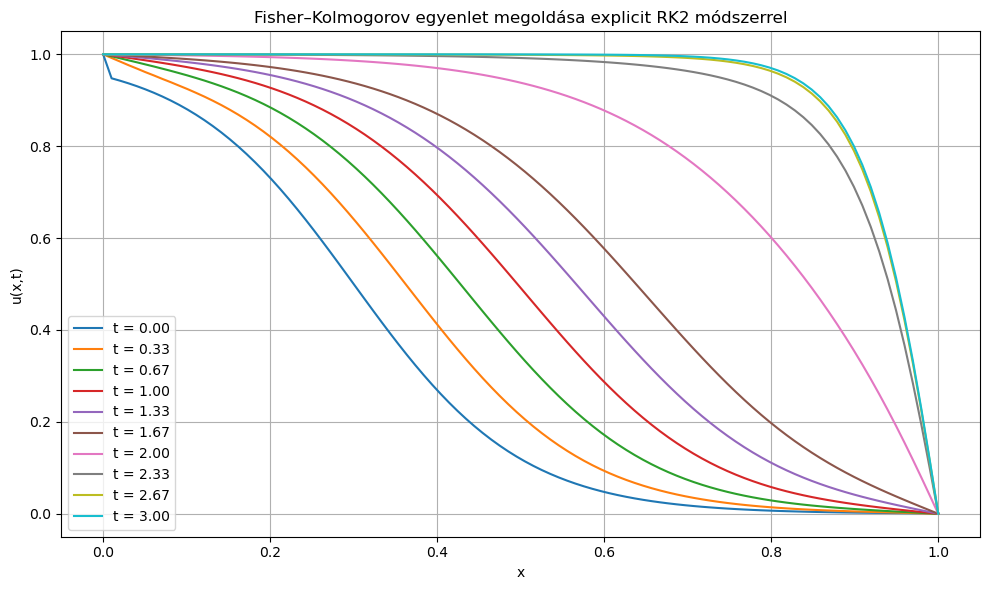

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

# Paraméterek
nu = 0.01
r = 4.0
L = 1.0
T = 3.0

Nx = 100
Nt = 600
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]
dt = T / Nt

u_left, u_right = 1.0, 0.0

# Kezdeti feltétel
u = 1 / (1 + np.exp(10 * (x - 0.3)))

# Laplace-operátor (explicit diffúzióhoz, belső pontokra)
main_diag = -2.0 * np.ones(Nx - 2)
off_diag  =  1.0 * np.ones(Nx - 3)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]).toarray() / dx**2

# Segédfüggvény: reakció
def f_react(u_vec):
    return r * u_vec * (1 - u_vec)

# Teljes jobb oldal: diffúzió + reakció
def rhs(u_inner):
    diff = nu * laplacian @ u_inner
    react = f_react(u_inner)
    return diff + react

# Snapshotok
snap_indices = {0,
                int(0.05*Nt), int(0.10*Nt), int(0.15*Nt), int(0.20*Nt), int(0.25*Nt),
                int(0.40*Nt), int(0.60*Nt), int(0.80*Nt), Nt}
snapshots = []

def save_snapshot(u_inner):
    u_full = np.empty_like(u)
    u_full[0], u_full[-1] = u_left, u_right
    u_full[1:-1] = u_inner
    snapshots.append(u_full)

# Kezdeti állapot
u_inner = u[1:-1].copy()
save_snapshot(u_inner)

# Időintegrálás RK2-vel (Heun-módszer)
for n in range(1, Nt + 1):
    # 1. stádium (Euler-lépés)
    k1 = rhs(u_inner)

    # Dirichlet perem feltételek hatása a diffúzióra
    k1[0] += nu * u_left / dx**2
    k1[-1] += nu * u_right / dx**2

    u_tmp = u_inner + dt * k1

    # 2. stádium
    k2 = rhs(u_tmp)
    k2[0] += nu * u_left / dx**2
    k2[-1] += nu * u_right / dx**2

    # RK2 frissítés
    u_inner = u_inner + 0.5 * dt * (k1 + k2)

    # Snapshot mentés
    if n in snap_indices:
        save_snapshot(u_inner)

# Ábrázolás
plt.figure(figsize=(10, 6))
for i, snap in enumerate(snapshots):
    plt.plot(x, snap, label=f"t = {i * T / (len(snapshots)-1):.2f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Fisher–Kolmogorov egyenlet megoldása explicit RK2 módszerrel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


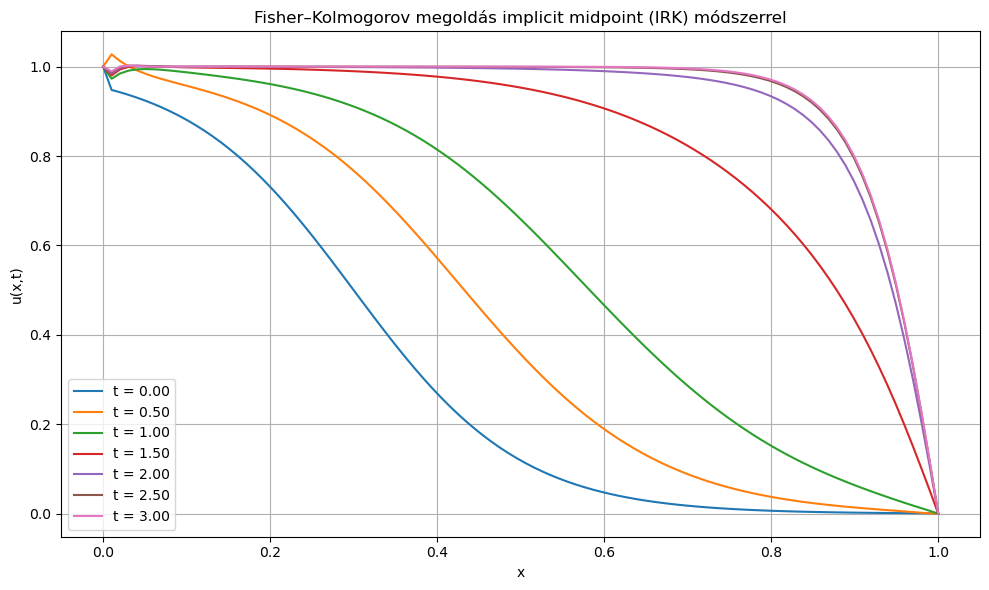

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, csr_matrix
from scipy.sparse.linalg import spsolve, norm as sparse_norm

# --- paraméterek -------------------------------------------------------------
nu = 0.01      # diffúziós együttható
r  = 4.0       # reakcióparaméter
L  = 1.0       # tartomány hossza
T  = 3.0       # végidő

Nx = 100       # rácspontok száma
Nt = 10      # időlépések száma
x  = np.linspace(0, L, Nx)
dx = x[1] - x[0]
dt = T / Nt

u_left, u_right = 1.0, 0.0                 # Dirichlet-peremek

# --- kezdeti profil ----------------------------------------------------------
u = 1.0 / (1.0 + np.exp(10 * (x - 0.3)))
u_inner = u[1:-1].copy()                

# --- diffúziós Laplace-operátor (belső pontokra) -----------------------------
main  = -2.0 * np.ones(Nx - 2)
off   =  1.0 * np.ones(Nx - 3)
Lmat  = diags([off, main, off], [-1, 0, 1], dtype=float) / dx**2
Lmat  = (nu * Lmat).tocsr()                # méret (Nx-2)×(Nx-2)

# perem miatt állandó vektor
b_vec = np.zeros(Nx - 2)
b_vec[0]  = nu * u_left  / dx**2           # bal Dirichlet-tag
b_vec[-1] = nu * u_right / dx**2           # jobb Dirichlet-tag

# --- reakciótag --------------------------------------------------------------
def reaction(v):
    return r * v * (1.0 - v)

# --- Newton-paraméterek ------------------------------------------------------
newton_tol   = 1e-10
newton_maxit = 12

I_mat = eye(Nx - 2, format='csr')

def implicit_midpoint_step(u_prev):
    v = u_prev.copy()          # kezdő iteráció (jobban konvergál, mint u_prev+dt*f)
    for _ in range(newton_maxit):
        w = 0.5 * (u_prev + v)
        F = (v - u_prev
         - dt * (Lmat @ w + b_vec + reaction(w)))
        if np.linalg.norm(F) < newton_tol:
            break

        J  = I_mat - 0.5 * dt * Lmat
        J -= diags(0.5 * dt * r * (1.0 - 2.0 * w), 0)

        delta = spsolve(J, -F)
        v += delta
        if np.linalg.norm(delta, np.inf) < newton_tol:
            break
    return v
# --- snapshotok --------------------------------------------------------------
snap_indices = {0,
                int(0.05*Nt), int(0.10*Nt), int(0.15*Nt), int(0.20*Nt), int(0.25*Nt),
                int(0.40*Nt), int(0.60*Nt), int(0.80*Nt), Nt}
snapshots = []

def save_snapshot(u_in):
    u_full = np.empty_like(u)
    u_full[0], u_full[-1] = u_left, u_right
    u_full[1:-1] = u_in
    snapshots.append(u_full)

save_snapshot(u_inner)

# --- időintegrálás -----------------------------------------------------------
for n in range(1, Nt + 1):
    u_inner = implicit_midpoint_step(u_inner)
    if n in snap_indices:
        save_snapshot(u_inner)

# --- ábrázolás ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
for i, snap in enumerate(snapshots):
    plt.plot(x, snap, label=f"t = {i * T / (len(snapshots)-1):.2f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Fisher–Kolmogorov megoldás implicit midpoint (IRK) módszerrel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
